###Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

#Set a style for the plots
plt.style.use('seaborn-v0_8-whitegrid')

#Define file paths
DATA_DIR = '../data'
TRAIN_FILE = os.path.join('ptb.train.txt')

#Verify that the file exists
if not os.path.exists(TRAIN_FILE):
    print("ERROR: Make sure your data is in the 'data/' directory")
    print(f"File not found: {TRAIN_FILE}")
else:
    print("Data file found. Ready to proceed.")

Data file found. Ready to proceed.


###Quick Look at the Data

In [2]:
#Printing the first 5 sentences from the training data
print("--- First 5 sentences of the training data ---")
with open(TRAIN_FILE, 'r') as f:
    for i, line in enumerate(f):
        if i >= 5:
            break
        print(f"Line {i+1}: {line.strip()}")

--- First 5 sentences of the training data ---
Line 1: aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter
Line 2: pierre <unk> N years old will join the board as a nonexecutive director nov. N
Line 3: mr. <unk> is chairman of <unk> n.v. the dutch publishing group
Line 4: rudolph <unk> N years old and former chairman of consolidated gold fields plc was named a nonexecutive director of this british industrial conglomerate
Line 5: a form of asbestos once used to make kent cigarette filters has caused a high percentage of cancer deaths among a group of workers exposed to it more than N years ago researchers reported


###Load and Tokenize the Full Corpus

Processing the entire training file to get a complete picture. We'll lowercase the text and build a flat list of all tokens and a list of all sentences.

In [3]:
#This list will hold all sentences (each as a list of words)
sentences = []
#This list will hold all words in one flat list for frequency counting
all_tokens = []

with open(TRAIN_FILE, 'r') as f:
    for line in f:
        tokens = line.strip().lower().split()
        sentences.append(tokens)
        all_tokens.extend(tokens)

#Calculate key statistics
num_sentences = len(sentences)
num_tokens = len(all_tokens)
vocab_size = len(set(all_tokens))

print(f"Total number of sentences: {num_sentences:,}")
print(f"Total number of tokens (corpus size): {num_tokens:,}")
print(f"Vocabulary size (unique words): {vocab_size:,}")

Total number of sentences: 42,068
Total number of tokens (corpus size): 887,521
Vocabulary size (unique words): 9,999


###Analyze Word Frequencies

We will now analyze the frequency distribution to understand how often words appear. This will tell us of the need for <unk> tokens and smoothing.

In [4]:
#Create a frequency counter
word_counts = Counter(all_tokens)
#Most common words
print("--- 15 Most Common Words ---")
for word, count in word_counts.most_common(15):
    print(f"{word:<15} | Count: {count:,}")

#Words that appear only once (Hapax Legomena)
hapax_legomena = [word for word, count in word_counts.items() if count == 1]
num_hapax = len(hapax_legomena)
percentage_hapax = (num_hapax / vocab_size) * 100

print("\n--- Analysis of Rare Words ---")
print(f"Number of words that appear only once: {num_hapax:,}")
print(f"Percentage of vocabulary that are single-occurrence words: {percentage_hapax:.2f}%")

--- 15 Most Common Words ---
the             | Count: 50,770
<unk>           | Count: 45,020
n               | Count: 32,481
of              | Count: 24,400
to              | Count: 23,638
a               | Count: 21,196
in              | Count: 18,000
and             | Count: 17,474
's              | Count: 9,784
that            | Count: 8,931
for             | Count: 8,927
$               | Count: 7,541
is              | Count: 7,337
it              | Count: 6,112
said            | Count: 6,027

--- Analysis of Rare Words ---
Number of words that appear only once: 30
Percentage of vocabulary that are single-occurrence words: 0.30%


OBSERVATION:

The most common words are function words like 'the', 'a', 'in', etc. This is expected.

A very large percentage of the vocabulary consists of words that appear only once. This is a powerful piece of evidence that if we don't use an <unk> token, the model will be extremely brittle.

###Visualizing the Word Frequency Distribution

A plot makes the "long tail" distribution immediately obvious. We'll create a log-log plot of word rank vs. frequency. This is a classic visualization of Zipf's Law.

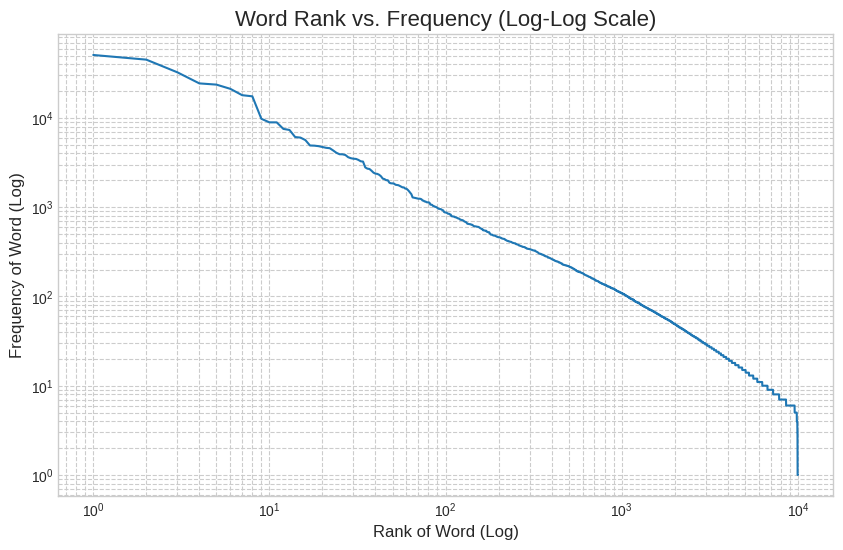

In [5]:
#Get frequencies and sort them in descending order
frequencies = sorted(word_counts.values(), reverse=True)
ranks = range(1, len(frequencies) + 1)

plt.figure(figsize=(10, 6))
plt.loglog(ranks, frequencies)
plt.title("Word Rank vs. Frequency (Log-Log Scale)", fontsize=16)
plt.xlabel("Rank of Word (Log)", fontsize=12)
plt.ylabel("Frequency of Word (Log)", fontsize=12)
plt.grid(True, which="both", ls="--")
plt.show()

The straight line on the log-log plot is a classic signature of a power-law distribution. It visually demonstrates that a tiny fraction of words (the "head" on the left) make up a huge portion of the text, while the vast majority of words (the "long tail" stretching to the right) are extremely rare. This plot is the perfect illustration of data sparsity.

###Analyze Sentence Lengths

This section is for checking the distribution of sentence lengths. This is good practice to understand the sequences the model will be working with.

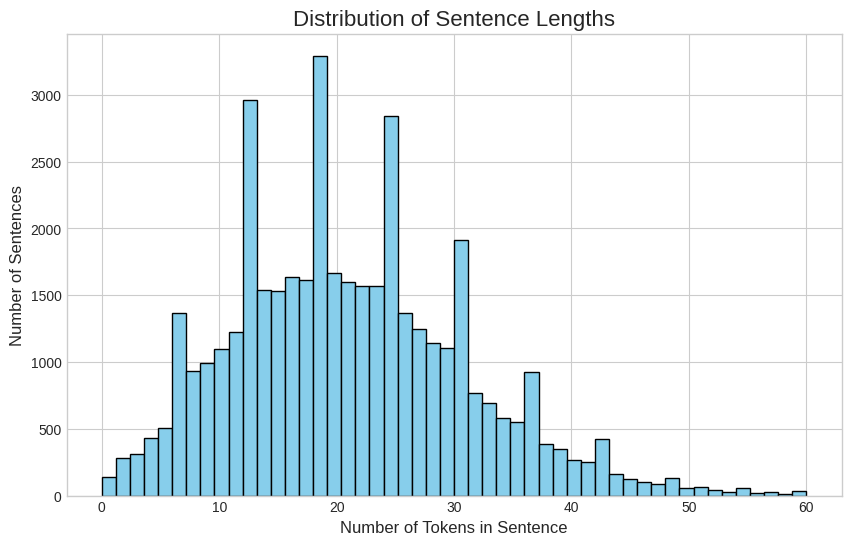


Average sentence length: 21.10 tokens
Median sentence length: 20.0 tokens
Maximum sentence length: 82 tokens


In [6]:
sentence_lengths = [len(s) for s in sentences]

plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=50, range=(0, 60), color='skyblue', edgecolor='black')
plt.title("Distribution of Sentence Lengths", fontsize=16)
plt.xlabel("Number of Tokens in Sentence", fontsize=12)
plt.ylabel("Number of Sentences", fontsize=12)
plt.show()

print(f"\nAverage sentence length: {np.mean(sentence_lengths):.2f} tokens")
print(f"Median sentence length: {np.median(sentence_lengths)} tokens")
print(f"Maximum sentence length: {np.max(sentence_lengths)} tokens")

OBSERVATION:

The histogram shows that most sentences are between 5 and 30 words long. This is just a good characterization of the dataset. For N-gram models it's less critical, but for RNNs or Transformers, this would be vital for setting sequence lengths.

###Summary Of Findings

Key Observations and Interpretations

- Corpus Size: With nearly 900,000 tokens and a vocabulary of 10,000 unique words, we are working with a standard-sized corpus.

- Most Common Words: It's dominated by a few very common function words ("the", "of", "to"). The presence of $ and 's shows the tokenizer was reasonably good.

- Sentence Length: The average sentence length of ~21 tokens, with most sentences falling between 10 and 30 tokens, is completely standard for written text like news articles. The model will be trained on sequences of a reasonable length.

- Word Frequency Plot (Zipf's Law): The log-log plot is a textbook example of Zipf's Law. The straight line confirms that a small number of words occur very frequently, while the vast majority of words are rare. This plot is the single best piece of visual evidence to explain why data sparsity is a problem and why smoothing techniques are necessary. The sharp drop-off at the far right is the vocabulary limit of 10,000 words.

- The "Missing" Rare Words: Only 0.30% of the vocabulary consists of words that appear once. So, the dataset has already been heavily pre-processed. The creators of the dataset already went through the training data, took all the words that weren't in the top 9,999 most frequent, and replaced them with the <unk> token. This is proven by two facts; The vocabulary size is a suspiciously round 9,999 and <unk> is the second most common token in your entire training set.

- The primary pre-processing tasks are to add sentence boundary tokens (<s>, </s>) and lowercasing, as the critical step of handling rare words via <unk> replacement was already performed on the source data.

- Validating the Model Design: The EDA validates every decision we've made. The Zipf plot proves smoothing is necessary. The high frequency of the <unk> token proves the vocabulary management in your code is essential.

CONCLUSION:

The data has no weird surprises. We can now proceed with the coding and experimentation phases with a solid, data-backed foundation.